# COQ4
Variants in COQ4 are associated with 
[Coenzyme Q10 deficiency, primary, 7; OMIM616276](https://omim.org/entry/616276) and 
[Spastic ataxia 10, autosomal recessive; OMIM:620666](https://omim.org/entry/620666).

Pathogenic COQ4 variants in exons 1-4 are associated with less life-threating presentations, late onset, responsiveness to CoQ10 therapy, and a relatively long lifespan ([Xie et al. (2021)](https://pubmed.ncbi.nlm.nih.gov/35154243/)). Correction for multiple testing was not performed.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


# COQ4
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for COQ4.

In [2]:
gene_symbol = 'COQ4'
mane_tx_id = 'NM_016035.5'
mane_protein_id = 'NP_057119.3' # ubiquinone biosynthesis protein COQ4 homolog, mitochondrial isoform 1 precursor

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 51/51 [00:00<00:00, 820.26 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
23,Increased circulating lactate concentration
17,Hypotonia
14,Lower limb hyperreflexia
14,Global developmental delay
13,Seizure
12,Lower limb spasticity
12,Babinski sign
11,Respiratory insufficiency
11,Cerebellar hypoplasia
10,Cerebellar atrophy


# Domains
Note that according to UniProt Q9Y3A0 (Ubiquinone biosynthesis protein COQ4 homolog, mitochondrial) there are no protein domains to display so we show only the location of the variants. For this reason we create an empty dataframe

/tmp/ipykernel_51528/617151761.py:16: DeprecationWarning: draw_protein_diagram was deprecated and will be removed in `1.0.0`. Use `draw_protein` instead
  visualizer.draw_protein_diagram(


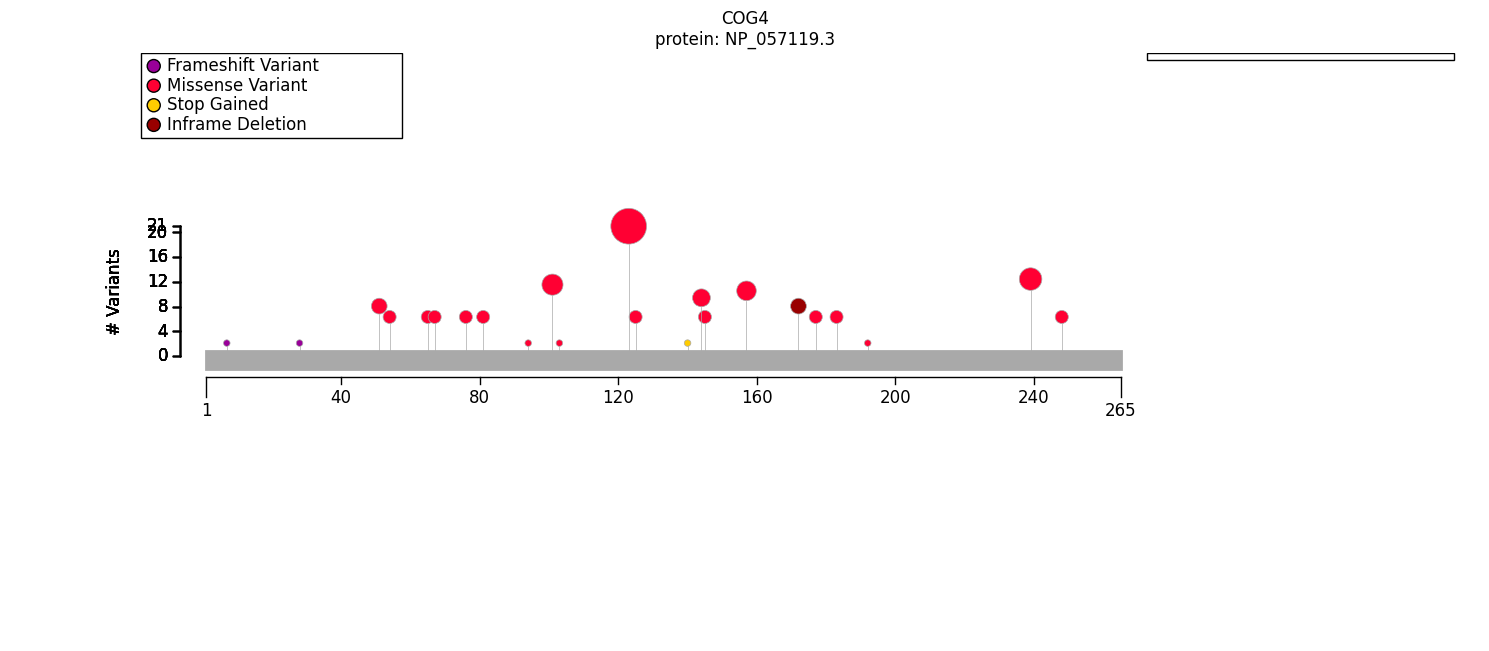

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
import pandas as pd
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
features = []
df = pd.DataFrame(features, columns=["region","category","start", "end"])
protein_meta = ProteinMetadata.from_feature_frame(protein_id=mane_protein_id, label="COG4", features=df, protein_length=265)


COG4_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
COG4_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import  biallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_clf = biallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="missense", 
    b_label="other",
    partitions=((1,0),(2,))
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skipping term because one genotype had zero observations,9
"Skipping ""general"" level terms",72
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),200


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense/other OR missense/missense,other/other,Corrected p values,p values
Cerebellar atrophy [HP:0001272],8/26 (31%),2/2 (100%),0.326087,0.119048
Lower limb spasticity [HP:0002061],14/22 (64%),0/2 (0%),0.326087,0.163043
Abnormal brain morphology [HP:0012443],26/26 (100%),2/2 (100%),1.000000,1.000000
Morphological central nervous system abnormality [HP:0002011],27/27 (100%),2/2 (100%),1.000000,1.000000


In [9]:
from gpsea.analysis.predicate import variant_key

is_g124s = variant_key("9_128325849_128325849_G_A") # c.370G>A	p.Gly124Ser
g124_clf = biallelic_classifier(
    a_predicate=is_g124s,
    b_predicate=~is_g124s,
    a_label="G124S",
    b_label= "other",
    partitions=((1,0),(2,))
)
g124_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf= g124_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=g124_result)

Allele group,G124S/other OR G124S/G124S,other/other,Corrected p values,p values
Increased circulating lactate concentration [HP:0002151],12/13 (92%),11/14 (79%),1.0,0.595556
Spasticity [HP:0001257],8/10 (80%),12/17 (71%),1.0,0.678389
Seizure [HP:0001250],11/13 (85%),12/13 (92%),1.0,1.000000
Acidosis [HP:0001941],12/12 (100%),11/11 (100%),1.0,1.000000
Abnormal muscle tone [HP:0003808],15/15 (100%),22/22 (100%),1.0,1.000000
Cerebellar atrophy [HP:0001272],4/12 (33%),6/16 (38%),1.0,1.000000
Lower limb spasticity [HP:0002061],4/6 (67%),10/18 (56%),1.0,1.000000
Appendicular spasticity [HP:0034353],4/6 (67%),11/16 (69%),1.0,1.000000
Hypotonia [HP:0001252],8/12 (67%),9/13 (69%),1.0,1.000000
Upper motor neuron dysfunction [HP:0002493],8/8 (100%),13/13 (100%),1.0,1.000000


In [10]:
# Test both variants at position 240	

r240c = variant_key("9_128333565_128333565_C_T") # c.718C>T	p.Arg240Cys
r240h= variant_key("9_128333566_128333566_G_A") # c.719G>A	p.Arg240His
r240var = r240c | r240h

r124_clf = biallelic_classifier(
    a_predicate=r240var,
    b_predicate=~r240var,
    a_label="G124S",
    b_label= "other",
    partitions=((1,0),(2,))
)
r124_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r124_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=r124_result)

Allele group,G124S/other OR G124S/G124S,other/other,Corrected p values,p values
Cerebellar atrophy [HP:0001272],0/4 (0%),10/24 (42%),1.0,0.265201
Increased circulating lactate concentration [HP:0002151],2/3 (67%),21/24 (88%),1.0,0.394530
Hypotonia [HP:0001252],3/3 (100%),14/22 (64%),1.0,0.526957
Spasticity [HP:0001257],3/5 (60%),17/22 (77%),1.0,0.579896
Acidosis [HP:0001941],2/2 (100%),21/21 (100%),1.0,1.000000
Seizure [HP:0001250],2/2 (100%),21/24 (88%),1.0,1.000000
Upper motor neuron dysfunction [HP:0002493],3/3 (100%),18/18 (100%),1.0,1.000000
Hypertonia [HP:0001276],3/3 (100%),18/18 (100%),1.0,1.000000
Lower limb spasticity [HP:0002061],3/5 (60%),11/19 (58%),1.0,1.000000
Appendicular spasticity [HP:0034353],3/5 (60%),12/17 (71%),1.0,1.000000


In [11]:
from gpsea.analysis.predicate import exon, anyof

e1 = exon(exon=1, tx_id=mane_tx_id)
e2 = exon(exon=2, tx_id=mane_tx_id)
e3 = exon(exon=3, tx_id=mane_tx_id)
e4 = exon(exon=4, tx_id=mane_tx_id)

exon_1_to_4 = anyof((e1, e2, e3, e4))
exon_1_to_4_clf = biallelic_classifier(
    a_predicate=exon_1_to_4,
    b_predicate=~exon_1_to_4,
    a_label="Exon 1-4",
    b_label= "other",
    partitions=((1,0),(2,))
)
exon_1_to_4_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=exon_1_to_4_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=exon_1_to_4_result)

Allele group,Exon 1-4/other OR Exon 1-4/Exon 1-4,other/other,Corrected p values,p values
Hypotonia [HP:0001252],11/19 (58%),6/6 (100%),0.915343,0.129170
Spasticity [HP:0001257],16/19 (84%),4/8 (50%),0.915343,0.144515
Lower limb spasticity [HP:0002061],10/14 (71%),4/10 (40%),0.915343,0.211233
Appendicular spasticity [HP:0034353],11/14 (79%),4/8 (50%),1.000000,0.342621
Seizure [HP:0001250],20/22 (91%),3/4 (75%),1.000000,0.407692
Upper motor neuron dysfunction [HP:0002493],17/17 (100%),4/4 (100%),1.000000,1.000000
Hypertonia [HP:0001276],17/17 (100%),4/4 (100%),1.000000,1.000000
Acidosis [HP:0001941],18/18 (100%),5/5 (100%),1.000000,1.000000
Increased circulating lactate concentration [HP:0002151],18/21 (86%),5/6 (83%),1.000000,1.000000
Abnormal brain morphology [HP:0012443],19/19 (100%),9/9 (100%),1.000000,1.000000


# Summary

In [12]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ), GPAnalysisResultSummary.from_multi(
        result=g124_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=r124_result,
    ), 
    GPAnalysisResultSummary.from_multi(
        result=exon_1_to_4_result,
    ), 
)

cohort_name = gene_symbol

report = GpseaAnalysisReport(
    name=cohort_name,
    cohort=cohort,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense/other OR missense/missense,other/other,4,0
Genotype (A),Genotype (B),Tests performed,Significant tests
G124S/other OR G124S/G124S,other/other,13,0
Genotype (A),Genotype (B),Tests performed,Significant tests
G124S/other OR G124S/G124S,other/other,13,0
Genotype (A),Genotype (B),Tests performed,Significant tests
Exon 1-4/other OR Exon 1-4/Exon 1-4,other/other,13,0


In [14]:
summarizer.process_latex(report=report, protein_fig=COG4_fig)

Figure saved to ../../supplement/img/COQ4_protein_diagram-draft.pdf
Output to ../../supplement/tex/COQ4_summary_draft.tex
